<a href="https://colab.research.google.com/github/jmlDC/Truth-Thesis22-23/blob/Scraping-trial/ScrapingNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip3 install requests-html
!apt update
!apt install chromium-chromedriver
!pip3 install selenium
!pip3 install webdriver-manager

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.4.3 requires urllib3[socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.


In [80]:
# Needed for Selenium
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [81]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [82]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from requests_html import HTMLSession 

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [84]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Truth-Thesis22-23/"

In [85]:
## Politifact 
pagesToGet= 1
upperframe=[]  
site = "politifact"


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.

    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))

    
    filename= f"{dir + site}NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label'])
data.head()

processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30


,Statement,Link,Date,Source,Label
0,"“Since 2019, I've successfully lobbied for the...",https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Kathy Hoffman,true
1,A royal guard member collapsed because of the ...,https://www.politifact.com/factchecks/2022/sep...,"mber 16, 2022",Instagram posts,false
2,Photo shows Queen Elizabeth II checking the oi...,https://www.politifact.com/factchecks/2022/sep...,"mber 16, 2022",Viral image,false
3,“Incomes are up.”,https://www.politifact.com/factchecks/2022/sep...,"mber 16, 2022",Joe Biden,barely-true
4,Blake Masters does not support abortion except...,https://www.politifact.com/factchecks/2022/sep...,"mber 16, 2022",Senate Majority PAC,mostly-true


In [86]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

In [87]:
## Manila bulletin
pagesToGet= 1
upperframe=[]  
topic = "ukraine war"
site = "manilaBulletin"

data=pd.DataFrame(columns=['Statement','Link','Date',"Topic"])


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://mb.com.ph/page/'+str(page)+'/?s='+topic.replace(" ", "+")
    print(url)

    time.sleep(2)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')

    links=soup.find("article", {'class' : 'content-bar col-12 col-lg-12 order-1 col-xl order-xl-2'}).find_all('li',attrs={'class':'article'})
    print(len(links))
    
    filename= f"{dir}{site}-{topic}-NEWS-List.csv"    
    for j in links:
        frame=[]
        try:
          Statement = j.find('h4').find('a').text
          Link = j.find('h4',attrs={'class':'title'}).find('a')['href'].strip()
          Date = j.find('time', {'class': 'time-ago'})['data-time'][0:10].strip()
          frame.extend((Statement, Link, Date, topic))
        except Exception as e:
            pass

        data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)
data.to_csv(filename)
data.head()

processing page : 1
https://mb.com.ph/page/1/?s=ukraine+war
16


,Statement,Link,Date,Topic
0,Pope urges end to ‘senseless’ Ukraine war duri...,https://mb.com.ph/2022/09/14/pope-urges-end-to...,2022-09-14,ukraine war
1,Gatchalian seeks impact assessment of Russia-U...,https://mb.com.ph/2022/08/04/gatchalian-seeks-...,2022-08-04,ukraine war
2,"US sanctions Putin ‘girlfriend,’ more oligarch...",https://mb.com.ph/2022/08/03/us-sanctions-puti...,2022-08-03,ukraine war
3,Pacquiao-Yoo exhibition match to serve as char...,https://mb.com.ph/2022/07/20/pacquiao-yoo-exhi...,2022-07-20,ukraine war
4,Ukraine war to dominate G20 finance chief meet...,https://mb.com.ph/2022/07/15/ukraine-war-to-do...,2022-07-15,ukraine war


In [88]:
print(filename)

/content/gdrive/MyDrive/THESIS-MS/Truth-Thesis22-23/manilaBulletinukraine war-NEWS-List.csv


In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  print(url)

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')

  head=soup.find("article", {'id' : 'the-article-content'})
  # print(content.prettify())
  textList =soup.find("article", {'id' : 'the-article-content'}).find("section", {'class': 'article-content'}).find_all("p")
  
  
  row=[]
  try:
    Title = head.find('h2',{'class':'title'}).text.strip()
    Author = head.find('p',attrs={'class':'author'}).find('a').text[3:].strip()
    Date = head.find('p', attrs={'class': 'published'}).text[10:-9].strip(",") 
  except Exception as e:
      pass
  
  body = ""
  for t in textList:
    body += (t.text.replace('\u200b', '')) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://mb.com.ph/2022/09/14/pope-urges-end-to-senseless-ukraine-war-during-kazakhstan-visit/
https://mb.com.ph/2022/08/04/gatchalian-seeks-impact-assessment-of-russia-ukraine-war-on-ph/
https://mb.com.ph/2022/08/03/us-sanctions-putin-girlfriend-more-oligarchs-for-complicity-in-ukraine-war/
https://mb.com.ph/2022/07/20/pacquiao-yoo-exhibition-match-to-serve-as-charity-event-for-ukraine-war-victims/
https://mb.com.ph/2022/07/15/ukraine-war-to-dominate-g20-finance-chief-meeting-in-indonesia/
https://mb.com.ph/2022/06/27/ukraine-war-could-boost-illegal-drug-production-un/
https://mb.com.ph/2022/06/09/un-chief-warns-impact-of-ukraine-war-on-world-is-worsening/
https://mb.com.ph/2022/06/07/church-leader-calls-for-prayers-for-an-end-to-the-russia-ukraine-war/
https://mb.com.ph/2022/05/30/ph-reiterates-call-to-end-russia-ukraine-war-in-asean-russia-forum/
https://mb.com.ph/2022/05/23/ukraine-war-pandemic-push-colour-who-international-meet/
https://mb.com.ph/2022/05/10/putin-says-russia-defend

,Title,Author,Date,Text
0,Pope urges end to ‘senseless’ Ukraine war duri...,Agence-France-Presse,"September 14, 2022","NUR SULTAN, Kazakhstan – Pope Francis on Tuesd..."
1,Gatchalian seeks impact assessment of Russia-U...,Joseph Pedrajas,"August 4, 2022",Senator Sherwin Gatchalian wants an assessment...
2,"US sanctions Putin ‘girlfriend,’ more oligarch...",Agence-France-Presse,"August 3, 2022","WASHINGTON, United States – The United States ..."
3,Pacquiao-Yoo exhibition match to serve as char...,Carlo Anolin,"July 20, 2022",The showdown between Manny Pacquiao and DK Yoo...
4,Ukraine war to dominate G20 finance chief meet...,Agence-France-Presse,"July 15, 2022","BALI, Indonesia – Group of 20 finance minister..."


In [107]:
## ABS CBN
pagesToGet= 2
topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

for page in range(1,pagesToGet+1):
  url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
  print(url)

  driver.get(url)
  # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
  source = driver.page_source

  time.sleep(2)   
  soup = BeautifulSoup(source, 'html.parser')
  searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
  filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

  for x in searches:
    frame=[]
    Title = x.find('div', class_="gs-title").find("a").text.strip()
    Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
    Link = x.find('a', class_="gs-title")['href']
    frame.extend((Title, Link, Date, topic))

    data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



data.to_csv(filename)
driver.quit()
data





https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=3#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=3
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=4#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=4
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=5#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=5
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=6#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=6
https://news.abs-cbn.com/special-pages/search?q=Quee

,Title,Link,Date,Topic
0,Queen Elizabeth II begins solemn final journey...,https://news.abs-cbn.com/overseas/09/11/22/que...,"Sep 11, 2022",Queen Elizabeth Death
1,London Bridge: The protocol after Queen Elizab...,https://news.abs-cbn.com/overseas/09/09/22/lon...,"Sep 9, 2022",Queen Elizabeth Death
2,The death of Queen Elizabeth II: Thursday's ti...,https://news.abs-cbn.com/overseas/09/09/22/the...,"Sep 9, 2022",Queen Elizabeth Death
3,Netflix suspends 'The Crown' filming after que...,https://news.abs-cbn.com/entertainment/09/10/2...,"Sep 10, 2022",Queen Elizabeth Death
4,Death of Queen Elizabeth II: What happens next...,https://news.abs-cbn.com/spotlight/09/15/22/de...,4 days ago .,Queen Elizabeth Death
5,Queen Elizabeth II dies at 96 | ABS-CBN News,https://news.abs-cbn.com/overseas/09/09/22/que...,"Sep 9, 2022",Queen Elizabeth Death
6,Queen Elizabeth II: Record-breaking monarch | ...,https://news.abs-cbn.com/spotlight/09/09/22/qu...,"Sep 9, 2022",Queen Elizabeth Death
7,Operation Unicorn: The plan for Queen's death ...,https://news.abs-cbn.com/overseas/09/09/22/ope...,"Sep 9, 2022",Queen Elizabeth Death
8,Prince Philip's death has left 'huge void' for...,https://news.abs-cbn.com/overseas/04/11/21/pri...,"Apr 11, 2021",Queen Elizabeth Death
9,"Britain mourns, as Queen Elizabeth II dies | A...",https://news.abs-cbn.com/overseas/multimedia/p...,"Sep 9, 2022",Queen Elizabeth Death


In [115]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if ('multimedia/photo' in url):
    pass
  else:
    print(url)

    time.sleep(1)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
      
    row=[]
    
    Title = soup.find('h1',{'class':'news-title'}).text.strip()
    Author = soup.find('span',attrs={'class':'editor'}).text.strip()
    Date = soup.find('span', attrs={'class': 'date-posted'}).text.strip() 
    
    textList =soup.find("div", {'class' :'article-content'}).find_all("p")
    body = ""
    for t in textList:
      if (t.text != "RELATED VIDEO:"):
        body += (t.text) +"\n" 

    row.extend((Title, Author, Date, body))
    

    data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://news.abs-cbn.com/overseas/09/11/22/queen-elizabeth-ii-begins-solemn-final-journey
https://news.abs-cbn.com/overseas/09/09/22/london-bridge-the-protocol-after-queen-elizabeths-death
https://news.abs-cbn.com/overseas/09/09/22/the-death-of-queen-elizabeth-ii-thursdays-timeline
https://news.abs-cbn.com/entertainment/09/10/22/netflix-suspends-the-crown-filming-after-queens-death
https://news.abs-cbn.com/spotlight/09/15/22/death-of-queen-elizabeth-ii-what-happens-next
https://news.abs-cbn.com/overseas/09/09/22/queen-elizabeth-ii-dies-at-96
https://news.abs-cbn.com/spotlight/09/09/22/queen-elizabeth-ii-record-breaking-monarch
https://news.abs-cbn.com/overseas/09/09/22/operation-unicorn-the-plan-for-queens-death-in-scotland
https://news.abs-cbn.com/overseas/04/11/21/prince-philips-death-has-left-huge-void-for-queen-elizabeth-ii-says-son-andrew


,Title,Author,Date,Text
0,Queen Elizabeth II begins solemn final journey...,"Callum Paton and Danny Kemp, Agence France-Presse",Sep 11 2022 11:09 AM,LONDON (UPDATE) — Queen Elizabeth II embarks o...
1,Operation London Bridge: What happens after th...,Deutsche Welle,Sep 09 2022 12:41 PM,"The day has come, setting into motion a minute..."
2,The death of Queen Elizabeth II: Thursday's ti...,"Helen Rowe, Agence France-Presse",Sep 09 2022 03:24 AM,LONDON (UPDATE) - A rare palace announcement a...
3,Netflix suspends 'The Crown' filming after dea...,Agence France-Presse,Sep 10 2022 10:56 AM,Netflix suspended filming of its British royal...
4,Death of Queen Elizabeth II: What happens next?,Agence France-Presse,Sep 15 2022 07:52 PM,As preparations build for next week's state fu...


In [167]:
# https://www.gmanetwork.com/news/#/search;query=queen%20elizabeth%20death;sortBy=_score;isDesc=1

topic = "Queen Elizabeth Death"
site = "GMA-Network"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

url = 'https://www.gmanetwork.com/news/#/search;query='+topic.replace(" ", "%20")+';sortBy=_score;isDesc=1'
print(url)

driver.get(url)
WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'clearfix'))) 
source = driver.page_source

time.sleep(2)   
soup = BeautifulSoup(source, 'html.parser')
searches = soup.find_all('div', {'class':'zd-row-text-wrap'})
filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

for x in searches:
  frame=[]
  Title = x.find('h4', class_="zd-result-title ng-star-inserted").text.strip()
  Date = x.find('div', class_="zd-result-subTitle ng-star-inserted").text[:-18].strip()
  partialTitle = ' '.join(Title.split()[:8])
  to_Click = driver.find_element(By.XPATH, f"//*[contains(text(), '{partialTitle}')]")
  #  //*[@id="zoomd-widget-wrapper"]/div[2]/div/zoomd-search-results[2]/section/div[1]/div/div[1]/div[1]/div[3]/div/zoomd-search-result-wrapper/zoomd-search-result-layout-tiles/div/div[2]/h4
  print(to_Click.text)
  # print(Title, Date)
  Link = " "  #x.find('a', class_="gs-title")['href']
  frame.extend((Title, Link, Date, topic))

  data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)
data.to_csv(filename)
driver.quit()
data


https://www.gmanetwork.com/news/#/search;query=Queen%20Elizabeth%20Death;sortBy=_score;isDesc=1
Death of Queen Elizabeth II: What happens next?
Senate adopts resolution expressing condolences over death of Queen Elizabeth II


InvalidSelectorException: ignored

<html lang="en" class=" zoomd-html"><head><link rel="stylesheet" type="text/css" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.3.0/css/font-awesome.min.css"><iframe id="pxcelframe" title="pxcelframe" src="//t.sharethis.com/a/t_.htm?ver=1.1042.23346&amp;cid=c010#rnd=1663600899882&amp;cid=c010&amp;dmn=www.gmanetwork.com&amp;gdpr_domain=false&amp;tt=t.dhj&amp;dhjLcy=425&amp;lbl=pxcel&amp;flbl=pxcel&amp;ll=d&amp;ver=1.1042.23346&amp;ell=d&amp;cck=__stid&amp;pn=%2Fnews%2F&amp;qs=na&amp;rdn=www.gmanetwork.com&amp;rpn=%2Fnews%2F&amp;rqs=na&amp;cc=US&amp;cont=NA&amp;ipaddr=" style="display: none;"></iframe><script type="text/javascript" id="async-buttons" src="https://ws.sharethis.com/button/async-buttons.js"></script><script src="https://connect.facebook.net/en_US/sdk.js?hash=a81d7459eecb4f48e601197f6c577bc4" async="" crossorigin="anonymous"></script><script src="https://rules.quantcount.com/rules-p-ernMzxMzj4rTH.js" async=""></script> <meta charset="utf-8"> <meta http-equiv="X-UA-Comp
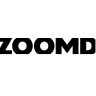

In [118]:
print(source)